In [1]:
import pandas as pd
import numpy as np
from numpy import round
from numpy import nan
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.api import ARMA as arma
from datetime import datetime
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA as arima
from statsmodels.tsa.arima_model import ARIMAResults as arima_results
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Bring in zillow data
zillowDataURL="https://files.zillowstatic.com/research/public/Zip/Zip_Zhvi_SingleFamilyResidence.csv"
zillowData=pd.read_csv(zillowDataURL, engine='python' )
zillowData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30416 entries, 0 to 30415
Columns: 293 entries, RegionID to 2020-01
dtypes: float64(260), int64(29), object(4)
memory usage: 68.0+ MB


In [3]:
#Remove NA's
zillowData.dropna(axis=0, how='any', inplace=True)
zillowData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12306 entries, 1 to 30392
Columns: 293 entries, RegionID to 2020-01
dtypes: float64(260), int64(29), object(4)
memory usage: 27.6+ MB


In [4]:
#Create data frame
zillowDF=pd.DataFrame(zillowData)
print(zillowDF)

       RegionID  RegionName              City State  \
1         84654       60657           Chicago    IL   
3         91982       77494              Katy    TX   
4         84616       60614           Chicago    IL   
5         91940       77449              Katy    TX   
7         91733       77084           Houston    TX   
...         ...         ...               ...   ...   
30367     95851       89155         Las Vegas    NV   
30375     82132       55144  North Saint Paul    MN   
30387     59316        4033        Cumberland    ME   
30390     95186       86343        Crown King    AZ   
30392     58952        2872        Portsmouth    RI   

                                  Metro         CountyName  SizeRank  \
1              Chicago-Naperville-Elgin        Cook County         2   
3      Houston-The Woodlands-Sugar Land      Harris County         4   
4              Chicago-Naperville-Elgin        Cook County         5   
5      Houston-The Woodlands-Sugar Land      Harris

In [5]:
#Column clean up
##Drop RegionID, 1996 data, 2019 data, 2020 data
zillow=zillowDF.drop(columns=['RegionID','1996-04','1996-05','1996-06'
                              ,'1996-07','1996-08','1996-09','1996-10'
                              ,'1996-11','1996-12','2019-01','2019-02'
                              ,'2019-03','2019-04','2019-05','2019-06'
                              ,'2019-07','2019-08','2019-09','2019-10'
                              ,'2019-11','2019-12','2020-01'])
##Rename RegionName to zipcode
zillow.rename(columns={'RegionName':'zipcode'}, inplace=True)
print(zillow)

       zipcode              City State                             Metro  \
1        60657           Chicago    IL          Chicago-Naperville-Elgin   
3        77494              Katy    TX  Houston-The Woodlands-Sugar Land   
4        60614           Chicago    IL          Chicago-Naperville-Elgin   
5        77449              Katy    TX  Houston-The Woodlands-Sugar Land   
7        77084           Houston    TX  Houston-The Woodlands-Sugar Land   
...        ...               ...   ...                               ...   
30367    89155         Las Vegas    NV      Las Vegas-Henderson-Paradise   
30375    55144  North Saint Paul    MN  Minneapolis-St. Paul-Bloomington   
30387     4033        Cumberland    ME           Portland-South Portland   
30390    86343        Crown King    AZ                          Prescott   
30392     2872        Portsmouth    RI                Providence-Warwick   

              CountyName  SizeRank   1997-01   1997-02   1997-03   1997-04  \
1        

In [6]:
#Subset Arkansas
Ark= zillow[zillow['State']=='AR']

In [7]:
pd.options.display.max_rows = 200
print(Ark)

       zipcode                  City State  \
331      71913           Hot Springs    AR   
663      72034                Conway    AR   
868      72701          Fayetteville    AR   
913      72764            Springdale    AR   
1230     72401             Jonesboro    AR   
1582     72758                Rogers    AR   
1643     72756                Rogers    AR   
1661     72703          Fayetteville    AR   
1663     72076          Jacksonville    AR   
1854     72450             Paragould    AR   
1903     71854             Texarkana    AR   
1964     72712           Bentonville    AR   
2228     72120              Sherwood    AR   
2262     72023                 Cabot    AR   
2353     72762            Springdale    AR   
2446     72143                Searcy    AR   
2610     72204           Little Rock    AR   
2691     72653         Mountain Home    AR   
2775     72032                Conway    AR   
2784     72956             Van Buren    AR   
2867     71901           Hot Sprin

In [8]:
searchfor=['Hot Springs','Little Rock','Fayetteville','Searcy']
ArkMetro= Ark[Ark['Metro'].str.contains('|'.join(searchfor))]
print(ArkMetro)

       zipcode                 City State  \
331      71913          Hot Springs    AR   
663      72034               Conway    AR   
868      72701         Fayetteville    AR   
913      72764           Springdale    AR   
1582     72758               Rogers    AR   
1643     72756               Rogers    AR   
1661     72703         Fayetteville    AR   
1663     72076         Jacksonville    AR   
1964     72712          Bentonville    AR   
2228     72120             Sherwood    AR   
2262     72023                Cabot    AR   
2353     72762           Springdale    AR   
2446     72143               Searcy    AR   
2610     72204          Little Rock    AR   
2775     72032               Conway    AR   
2867     71901          Hot Springs    AR   
3175     72209          Little Rock    AR   
3226     72704         Fayetteville    AR   
3549     72205          Little Rock    AR   
3568     72113             Maumelle    AR   
3824     72211          Little Rock    AR   
3985     7

In [9]:
#Split ArkMetro areas
HotSprings=ArkMetro[ArkMetro['Metro'].str.contains('Hot Springs')]
LittleRock=ArkMetro[ArkMetro['Metro'].str.contains('Little Rock')]
Fayetteville=ArkMetro[ArkMetro['Metro'].str.contains('Fayetteville')]
Searcy=ArkMetro[ArkMetro['Metro'].str.contains('Searcy')]

In [10]:
#Get Averages for areas
HSmean=HotSprings.iloc[:, 6:].mean(axis=0)
HSmean.index=pd.to_datetime(HSmean.index)
LRmean=LittleRock.iloc[:, 6:].mean(axis=0)
LRmean.index=pd.to_datetime(LRmean.index)
Fmean=Fayetteville.iloc[:, 6:].mean(axis=0)
Fmean.index=pd.to_datetime(Fmean.index)
Smean=Searcy.iloc[:, 6:].mean(axis=0)
Smean.index=pd.to_datetime(Smean.index)

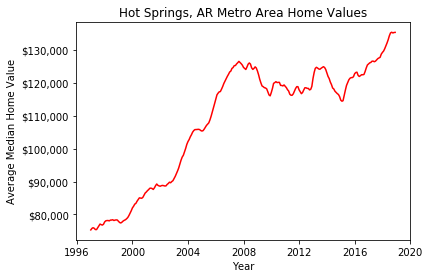

In [11]:
#Create Hot Springs Time Series Plot
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
fig, ax = plt.subplots()
plt.plot(HSmean.index,HSmean.values, color='red')
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xlabel('Year')
plt.xticks() 
plt.ylabel('Average Median Home Value')
plt.title('Hot Springs, AR Metro Area Home Values')
plt.show()

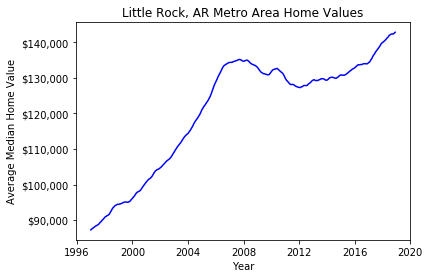

In [12]:
#Create Little Rock Time Series Plot
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
fig, ax = plt.subplots()
plt.plot(LRmean.index,LRmean.values,color='blue')
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xlabel('Year')
plt.xticks() 
plt.ylabel('Average Median Home Value')
plt.title('Little Rock, AR Metro Area Home Values')
plt.show()

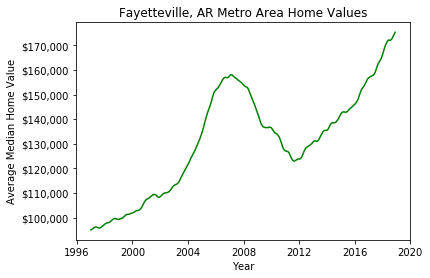

In [13]:
#Create Fayetteville Time Series Plot
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
fig, ax = plt.subplots()
plt.plot(Fmean.index,Fmean.values,color='green')
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xlabel('Year')
plt.xticks() 
plt.ylabel('Average Median Home Value')
plt.title('Fayetteville, AR Metro Area Home Values')
plt.show()

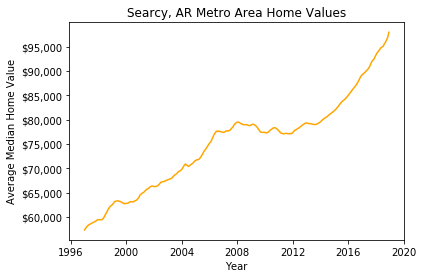

In [14]:
#Create Searcy Time Series Plot
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
fig, ax = plt.subplots()
plt.plot(Smean.index,Smean.values,color='orange')
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xlabel('Year')
plt.xticks() 
plt.ylabel('Average Median Home Value')
plt.title('Searcy, AR Metro Area Home Values')
plt.show()

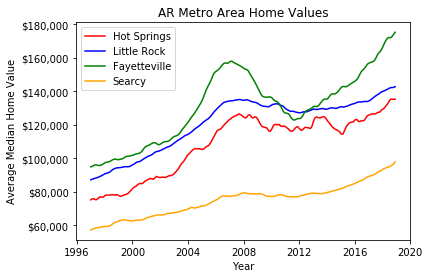

In [15]:
#Create Combined AR Time Series plot
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
fig, ax = plt.subplots()
plt.plot(HSmean.index,HSmean.values, color='red', label = 'Hot Springs')
plt.plot(LRmean.index,LRmean.values,color='blue', label = 'Little Rock')
plt.plot(Fmean.index,Fmean.values,color='green', label = 'Fayetteville')
plt.plot(Smean.index,Smean.values,color='orange', label = 'Searcy')
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xlabel('Year')
plt.xticks() 
plt.ylabel('Average Median Home Value')
plt.title('AR Metro Area Home Values')
plt.legend()
plt.show()

In [16]:
#Create Train Data
zillowTrain = zillow.iloc[:,6:258]
zillowTrain.columns=pd.to_datetime(zillowTrain.columns).to_period('M')
print(zillowTrain)

        1997-01   1997-02   1997-03   1997-04   1997-05   1997-06   1997-07  \
1      371534.0  374803.0  378707.0  380267.0  383619.0  383911.0  384723.0   
3      201586.0  202830.0  204106.0  206310.0  208766.0  210477.0  210146.0   
4      558397.0  561564.0  565262.0  567227.0  573304.0  576014.0  579402.0   
5       97196.0   96917.0   96658.0   96792.0   96931.0   97167.0   97353.0   
7       96488.0   96076.0   95738.0   95694.0   95708.0   95698.0   95793.0   
...         ...       ...       ...       ...       ...       ...       ...   
30367  195415.0  196102.0  196422.0  197168.0  197846.0  198450.0  198758.0   
30375   65814.0   65484.0   65609.0   65902.0   66371.0   66524.0   67145.0   
30387  329537.0  334031.0  335018.0  336421.0  336279.0  339943.0  344034.0   
30390   73583.0   75000.0   76257.0   77872.0   79188.0   80356.0   81986.0   
30392  137530.0  137695.0  138250.0  138410.0  139116.0  140890.0  142713.0   

        1997-08   1997-09   1997-10  ...    2017-03

In [17]:
#Create Test Data
zillowTest = zillow.iloc[:,258:]
zillowTest.columns=pd.to_datetime(zillowTest.columns).to_period('M')
print(zillowTest)

       2018-01  2018-02  2018-03  2018-04  2018-05  2018-06  2018-07  2018-08  \
1       950292   955924   955320   955253   956149   959502   959596   959026   
3       332781   333075   332992   333632   334747   335493   335310   335573   
4      1191457  1196204  1192896  1190428  1189842  1191476  1191534  1191305   
5       173288   173856   174533   175706   176758   177547   177933   178558   
7       169283   169770   170493   171779   173022   173957   174632   175510   
...        ...      ...      ...      ...      ...      ...      ...      ...   
30367   348684   352231   353454   355135   356522   359791   363649   368014   
30375   206822   208131   209669   212734   213610   213468   212666   212104   
30387   764610   776069   790471   798523   804663   806809   810728   816655   
30390   162760   162339   162532   162559   163556   163722   162671   161605   
30392   243448   242776   243714   244782   249487   250472   251955   252072   

       2018-09  2018-10  20

In [18]:
#Create Prediction DF
zillowPredict = pd.DataFrame(index=zillowTest.index, columns=zillowTest.columns)
zillowPredict.columns=zillowPredict.columns
zillowPredict.fillna(nan,inplace=True)
print(zillowPredict)

       2018-01  2018-02  2018-03  2018-04  2018-05  2018-06  2018-07  2018-08  \
1          NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
3          NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4          NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
5          NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
7          NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
...        ...      ...      ...      ...      ...      ...      ...      ...   
30367      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
30375      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
30387      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
30390      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
30392      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

       2018-09  2018-10  20

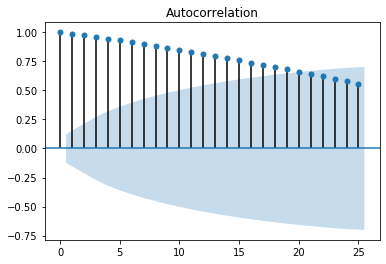

In [19]:
#Create ACF plot
TrainMean = zillowTrain.mean(axis=0)
plot_acf(TrainMean)
plt.show()

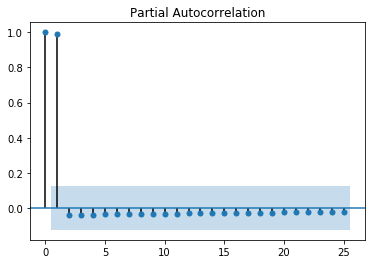

In [20]:
#Create PACF plot
plot_pacf(TrainMean)
plt.show()

In [ ]:
#Create ARIMA model for each zip code
for i in zillowTrain.index:
    zillowTrainSeries = zillowTrain.loc[i]
    try:
        model=arima(zillowTrainSeries, order=(2,0,0))
        model_fit = model.fit()
    except:
        pass
    else:
        zillowPredict.loc[i] = model_fit.predict(start='2018-01', end='2018-12').apply(lambda x:round(x,1))
zillowPredict.dropna(axis=0, how='any', inplace=True)

In [ ]:
rmse = pd.DataFrame(index=zillowPredict.index, columns=['RMSE'])
rmse.fillna(nan, inplace=True)

for i in zillowPredict.index:
  rmse.loc[i] = round(sqrt(mean_squared_error(zillowTest.loc[i], zillowPredict.loc[i])), 1)

plt.plot(rmse.index, rmse.values)
plt.hlines(round(0.15*rmse.loc[:, 'RMSE'].max(), 1), xmin=0, xmax=rmse.index.max(), color='red')
plt.show()

In [ ]:
print(zillowPredict)